In [3]:
## Imports

%matplotlib widget
import numpy as np
from plantcv import plantcv as pcv

# Turn on plotting so intermediate images are plot to the screen 
pcv.params.debug = "plot" 


# Read in image data

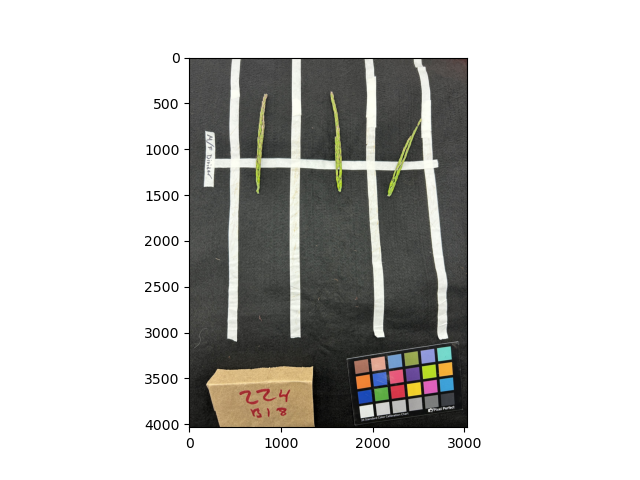

In [53]:
## Read img 

img, path, filename = pcv.readimage("./img/IMG_5880.jpg")


# Standardize colorspace (correct color) 

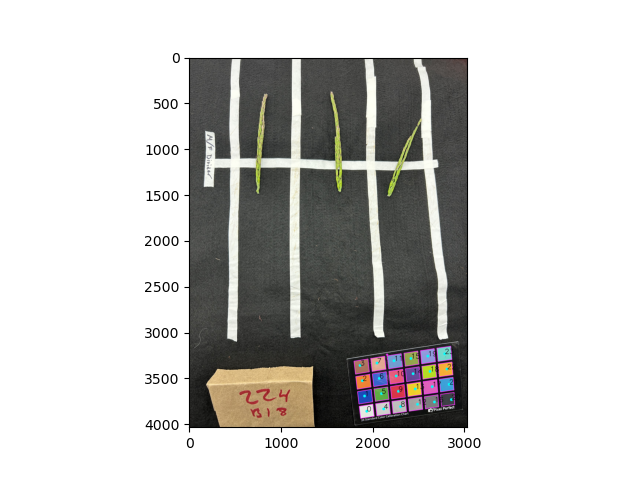

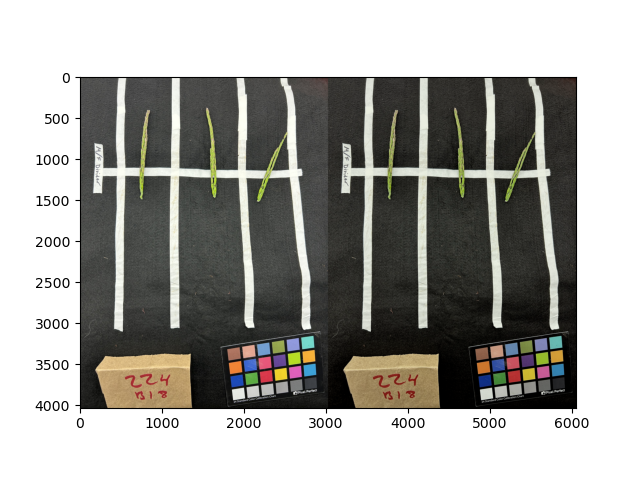

In [54]:
pcv.params.text_size = 2.5
pcv.params.verbose = False
# Perform color correction 
img = pcv.transform.auto_correct_color(rgb_img=img, radius=15)

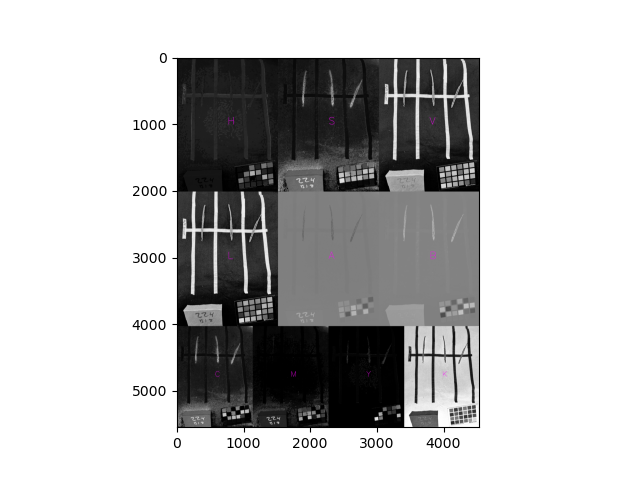

In [55]:
## Visualize all possible colorspaces
pcv.params.text_size = 10
pcv.params.text_thickness = 10
vis = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

# Segment whole flower

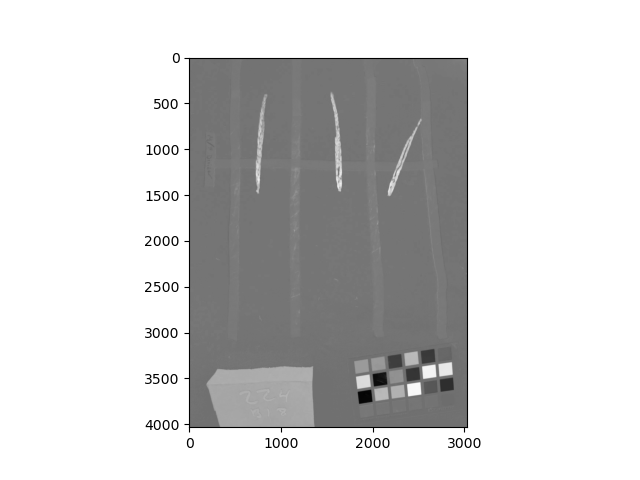

In [56]:
gray = pcv.rgb2gray_lab(rgb_img=img, channel="b")

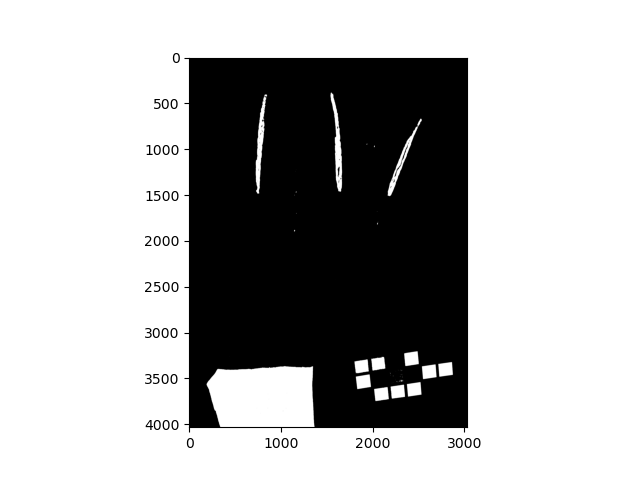

In [57]:
## Roughly segment the whole flower from the background 
total_flower = pcv.threshold.binary(gray_img=gray, threshold=145, object_type="light")

### Clean mask

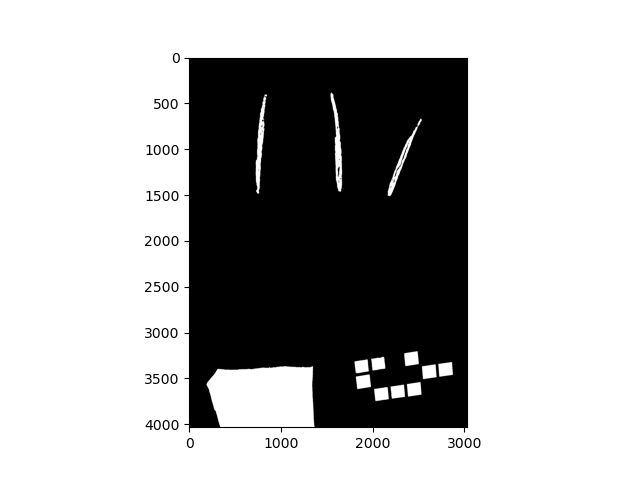

In [58]:
## Fill small objects to clean up the mask
total_flower_filled = pcv.fill(total_flower, size=500)

### Remove color card from whole-flower mask

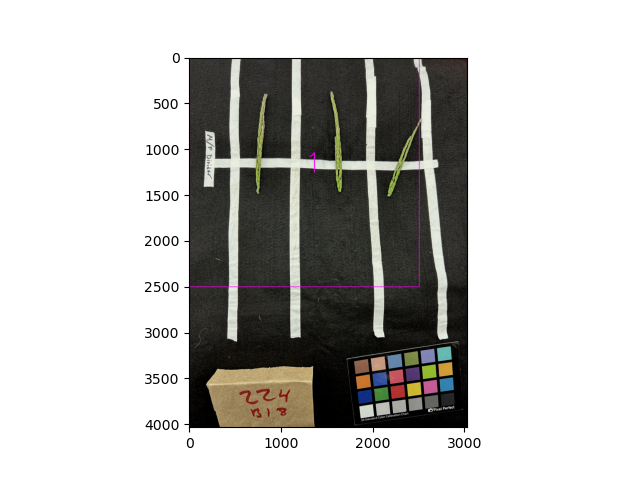

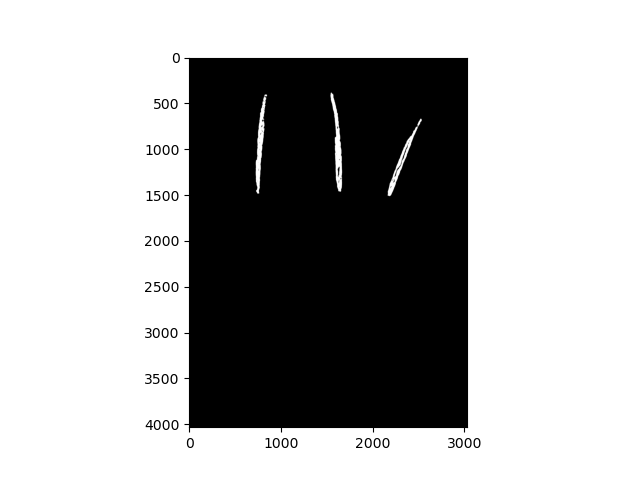

In [59]:
## Define a region of interest to remove the color card
roi = pcv.roi.rectangle(img=img, x=5, y=5, h=2500, w=2500)  ## appropriate for KU data

total_flower_clean = pcv.roi.filter(roi=roi, mask=total_flower_filled, roi_type="partial")

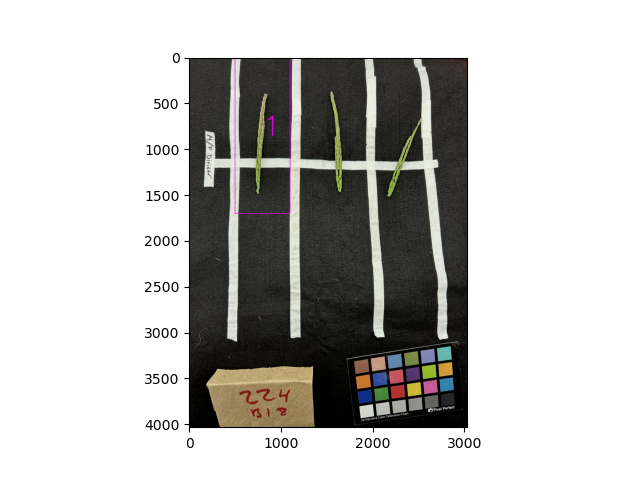

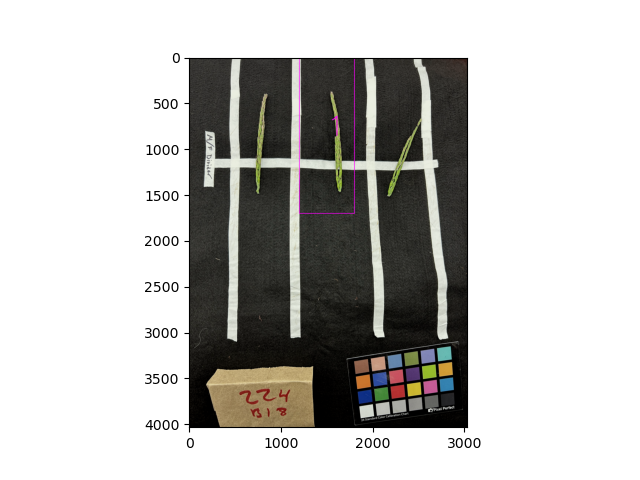

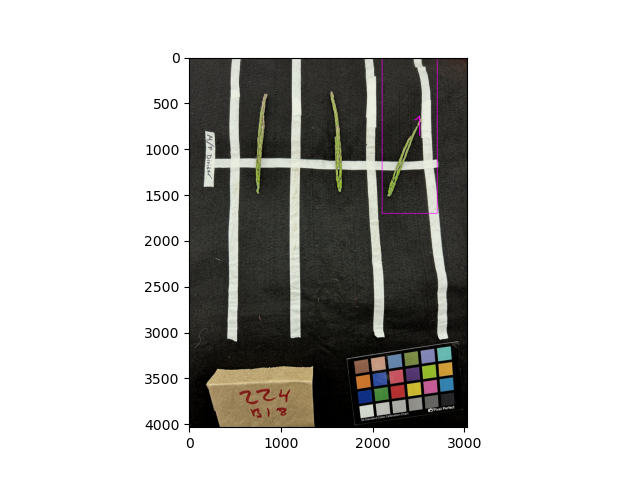

In [60]:
# Custom multi-rectangle ROI defining
start_coords = [500, 1200, 2100]  # starting x-coordinates of each rectangle 
multi_roi = pcv.Objects() 
ref_img = img
for i in range(3):
    roi1 = pcv.roi.rectangle(img=ref_img, x=start_coords[i], y=5, h=1700, w=600)  ## appropriate for KU data
    multi_roi.append(roi1.contours, roi1.hierarchy)

# Create a labeled mask 

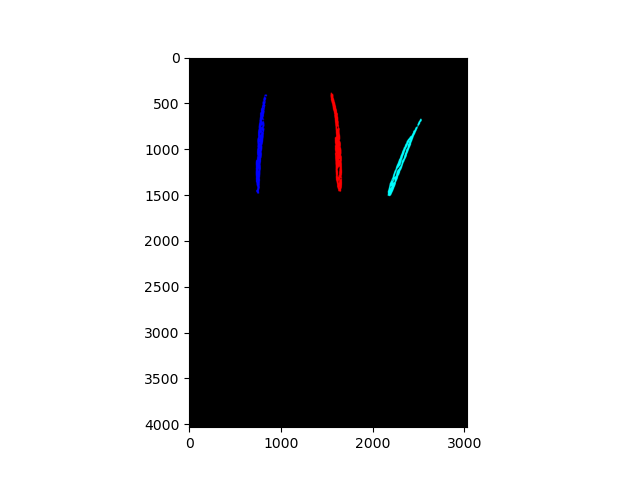

In [61]:
total_label, num_t = pcv.create_labels(mask=total_flower_clean, rois=multi_roi, roi_type="partial")


# Analyze above and below boundary line 

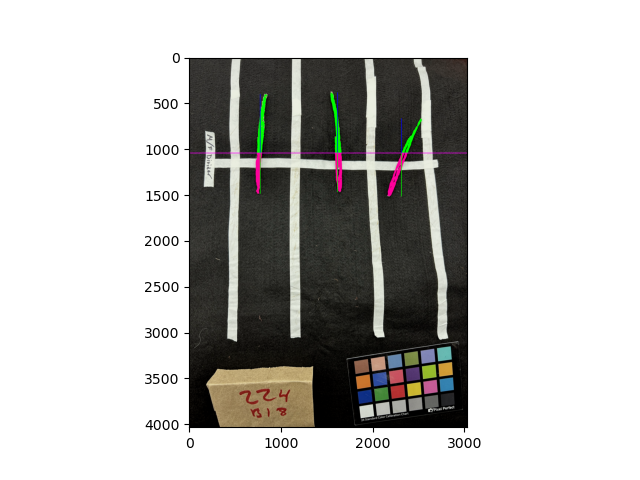

In [63]:
boundary_image = pcv.analyze.bound_horizontal(img=img, labeled_mask=total_label, line_position=1050, n_labels=num_t)


# Separate male and female flower part 

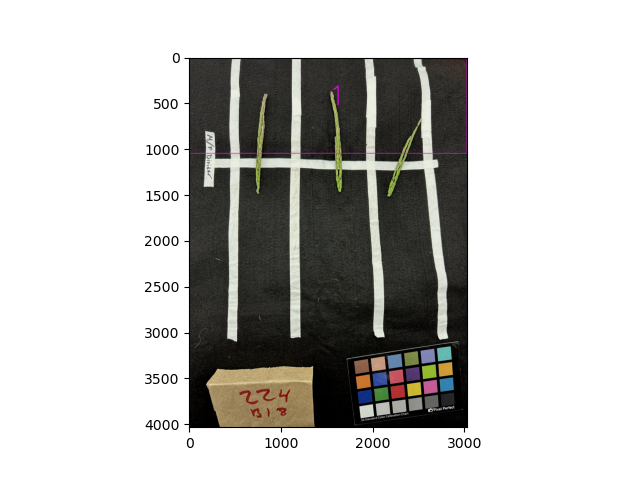

In [64]:
boundary_roi = pcv.roi.rectangle(img=img, x=0, y=0, h=1050, w=np.shape(img)[1])

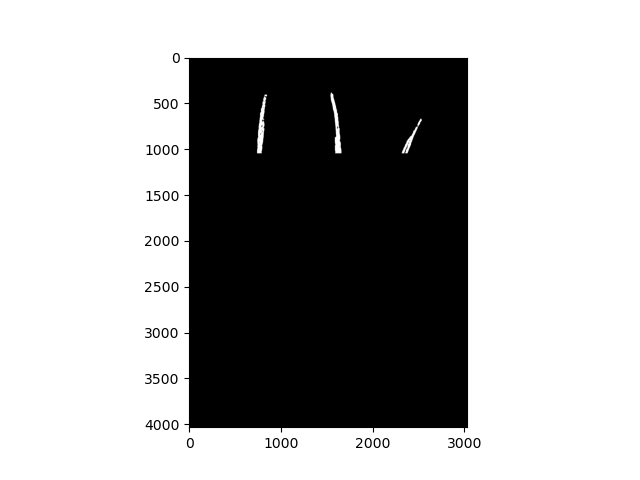

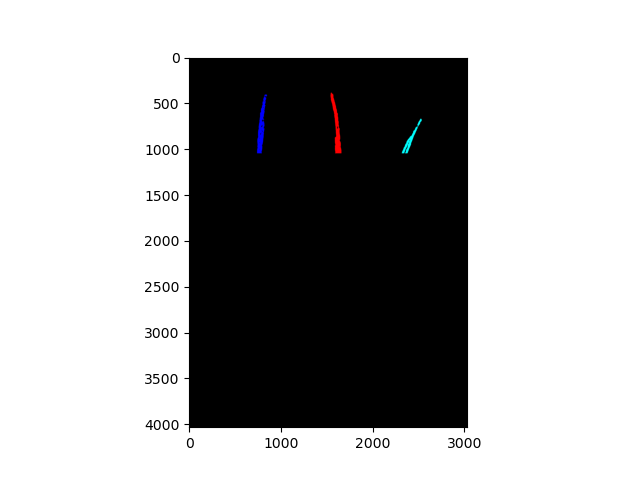

In [65]:
male_flower_mask = pcv.roi.filter(roi=boundary_roi, mask=total_flower_filled, roi_type="cutto")
male_label, num_m = pcv.create_labels(mask=male_flower_mask, rois=multi_roi)


# Subtract to get female part of flower

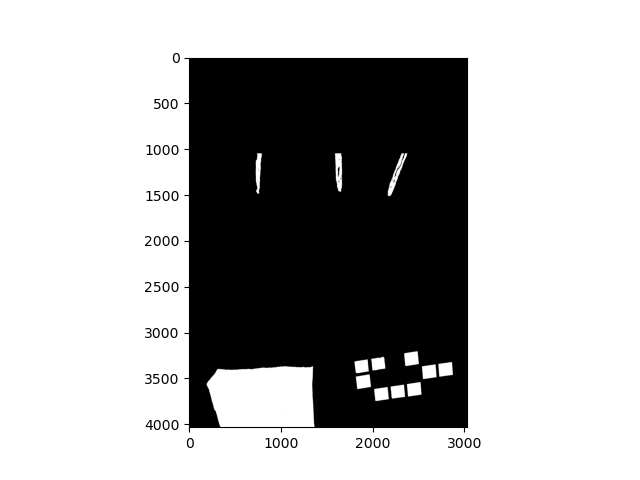

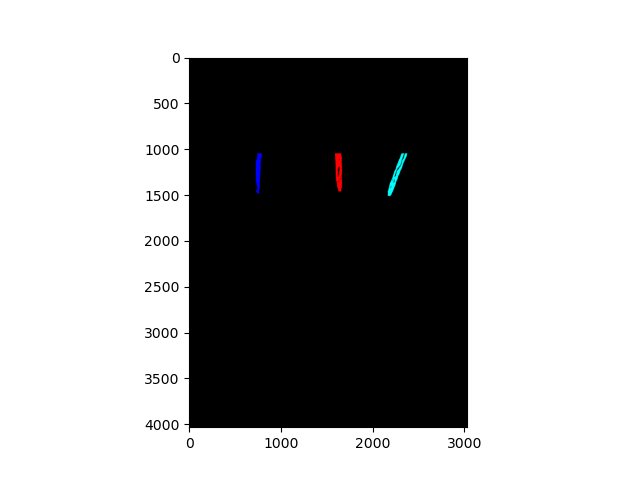

In [66]:
female_flower_mask = pcv.image_subtract(total_flower_filled, male_flower_mask)
female_label, num_f = pcv.create_labels(mask=female_flower_mask, rois=multi_roi)


# Measure sizes

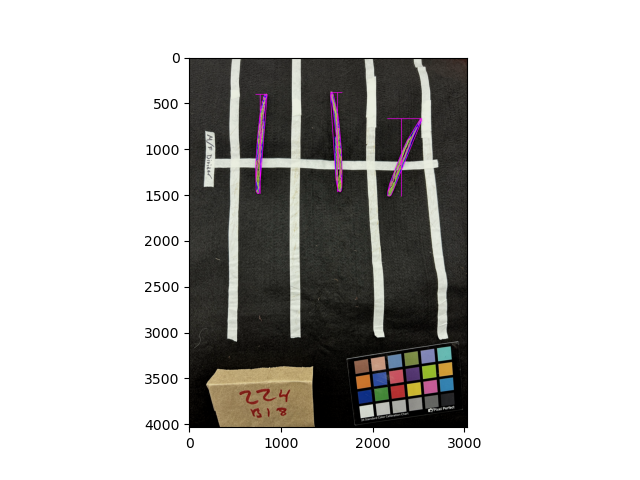

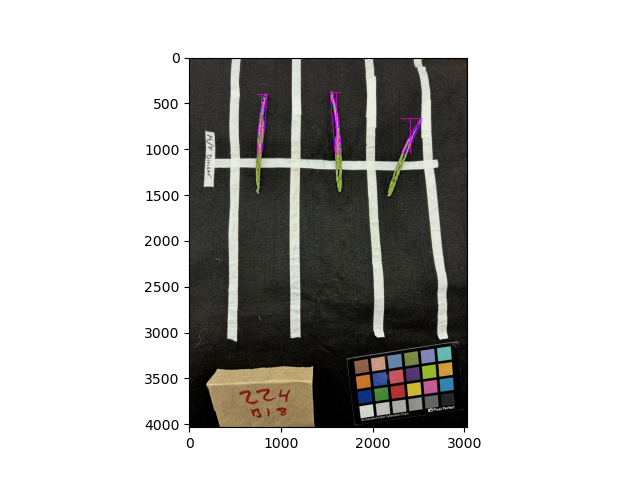

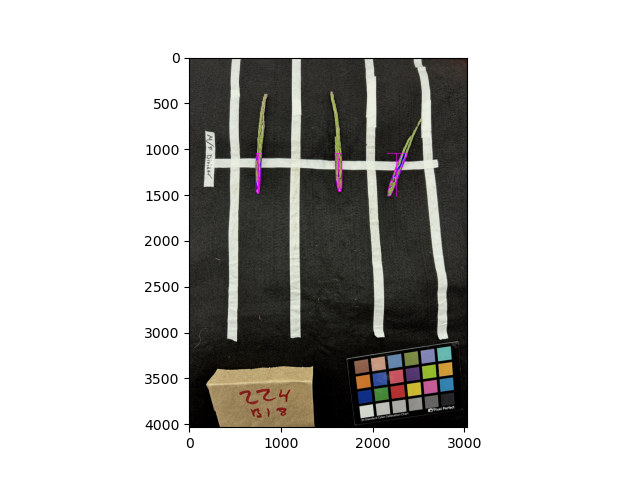

In [67]:
total_shape = pcv.analyze.size(img=img, labeled_mask=total_label, n_labels=num_t)
male_shape = pcv.analyze.size(img=img, labeled_mask=male_label, n_labels=num_m)
female_shape = pcv.analyze.size(img=img, labeled_mask=female_label, n_labels=num_f)


# Estimate seed number

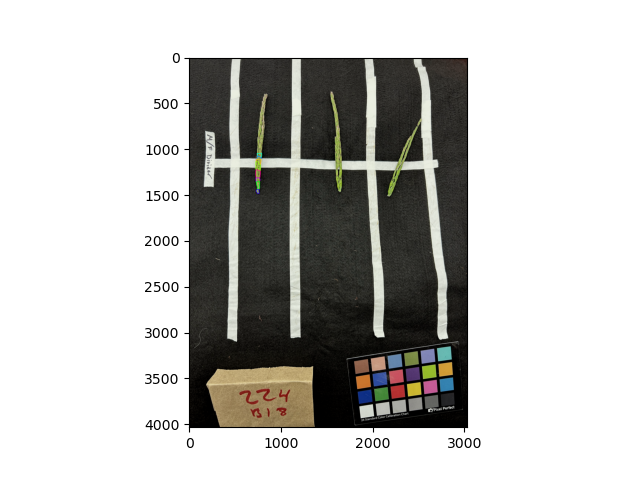

9


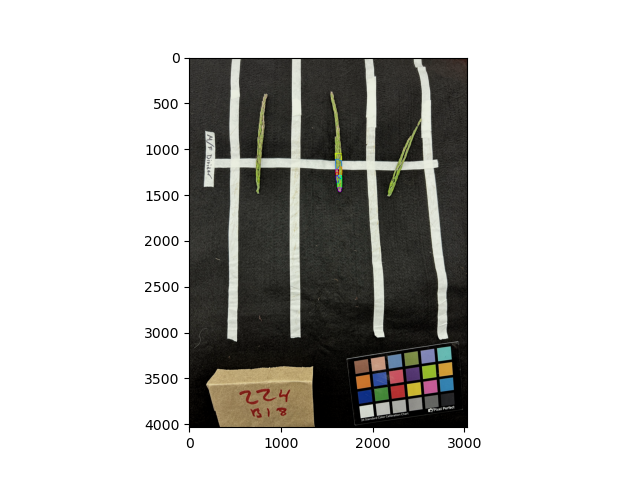

10


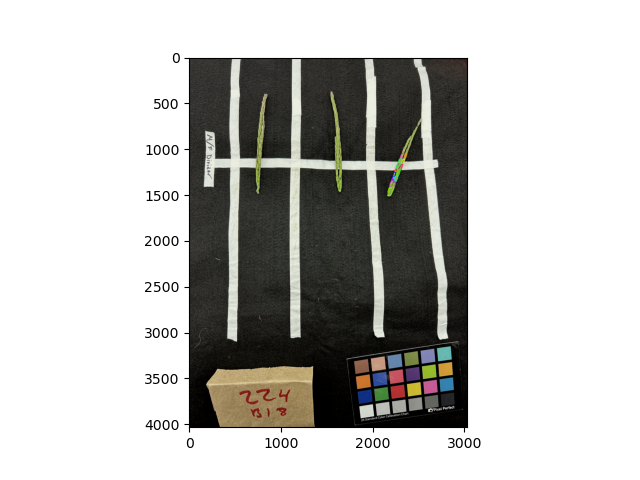

13


In [68]:
mask_copy = np.copy(female_label)
for i in [1,2,3]:
    submask = np.where(mask_copy == i, 255, 0).astype(np.uint8)
    labels = pcv.watershed_segmentation(rgb_img=img, mask=submask, distance=20, label=None)
    print(len(np.unique(labels))) 

# Crop out labeled Plant ID for recognition workflow 

Min value = 18167.0
Max value = 697664.0
Mean value = 78461.23076923077


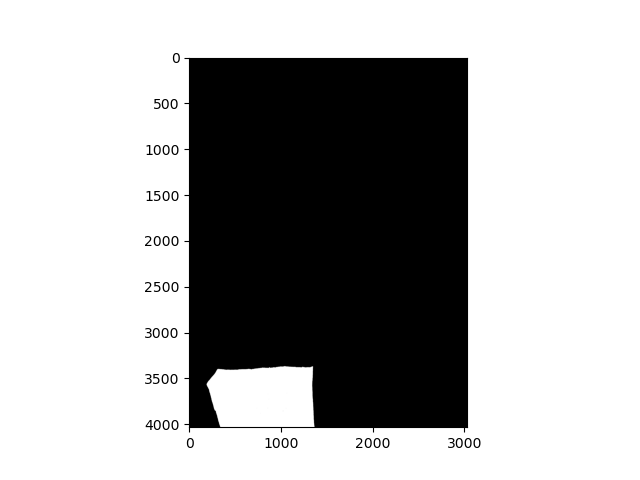

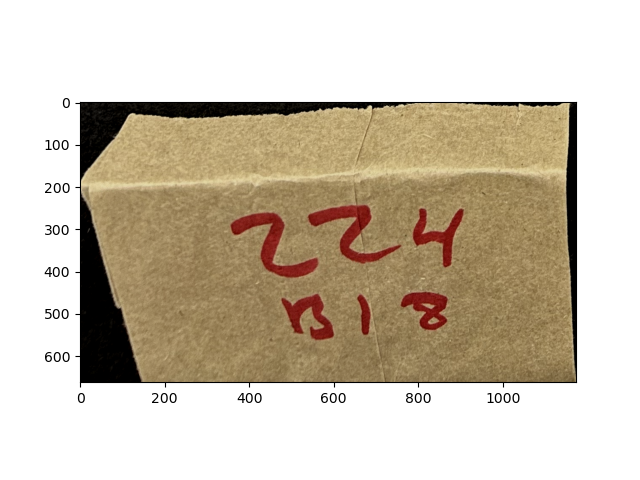

In [69]:
id_mask = pcv.filters.obj_props(bin_img=total_flower_filled, regprop="area", thresh=600000, cut_side="upper")
if np.sum(id_mask) > 0:
    cropped_id = pcv.auto_crop(img=img, mask=id_mask)
    # # Save to file
    # destination_file = os.path.join(args.outdir, filename)
    # pcv.print_image(cropped_id, filename=destination_file)

